In [1]:
from keras_facenet import FaceNet
from mtcnn.mtcnn import MTCNN

from sklearn.metrics.pairwise import cosine_similarity

from PIL import Image,ImageDraw
from PIL import ImageFilter
import cv2
import numpy as np
import matplotlib.pyplot as plt

import os
import glob
from pathlib import Path

folder = "Faces-Lock"
try:
    Path(folder).mkdir()
except:
    print('folder already exists')

folder already exists


In [3]:
def visual_multifaces(head_path,names):
    # head_path = "C:/Users/Raum/Desktop/jec/code/experimental/test_tourial/Faces-Lock"
    for index,i in enumerate(os.listdir(head_path)):
        files_path = os.path.join(head_path+'/'+i)
        nplots = os.listdir(files_path)
        fig = plt.figure(figsize=(8,4))
        print(f'{names[index]}')
        for j in range(len(nplots)):
            
            img = cv2.resize(cv2.imread(files_path+'/'+nplots[j]),(224,224))
            image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(4,10,j+1)
            plt.imshow(image_rgb)
            plt.title(j+1)
            plt.xticks([]);plt.yticks([])
        plt.show()

In [46]:
def detect_all(file_name): # take embeddings, and position
  embedder = FaceNet()
  detector = MTCNN()
  names = []
  images = []
  file_names = glob.glob(file_name)
  embedding_faces = {}
  data_position = {}
  crop_face = {}
  for i,image in enumerate(file_names):
    NAME = os.path.splitext(os.path.basename(image))[0]
    names.append(NAME)
    image = Image.open(image).convert('RGB')
    im_arr = np.array(image)
    images.append(im_arr)
    faces = detector.detect_faces(im_arr,)
    datafaces = []
    position_crop =  []
    for j in faces:
      x1,y1,width,height = j['box']
      x2,y2 = (x1+width),(y1+height)
      datafaces.append([x1,y1,x2,y2])
      position_crop.append([y1,y2,x1,x2])
    data_position[NAME] = datafaces
    crop_face[i] = position_crop # for embedding
    datafaces = []
    position_crop = []
    
  '''for delete file in image_lock'''
  if os.listdir(folder+'/') !=[]:
    for i in os.listdir(folder+'/'): 
        folder_folder = os.path.join(folder+'/',i)
        for i in os.listdir(folder_folder+'/'):
            os.remove(os.path.join(folder_folder+'/',i))
        os.rmdir(folder_folder)

  for i,img in enumerate(images):
      new_folder = folder+"/Faces_{}".format(names[i])
      try:
          os.makedirs(new_folder)
      except:
          print('folder already exists')
      index_image = 0
      EMBED = []
      for j in crop_face[i]:
        face = img[j[0]:j[1],j[2]:j[3]]
        image_face = Image.fromarray(face)
        image_face = image_face.resize((224,224))

        faces_crops = np.array(image_face).reshape(-1,224,224,3)
        EMBED.append(embedder.embeddings(faces_crops))

        index_image +=1
        path = new_folder+'/Face_{}.jpg'.format(index_image) # path for collect images
        image_face.save(path)
      embedding_faces[names[i]] = EMBED

  visual_multifaces(folder,names)
  return embedding_faces,data_position,names

In [177]:
def plot_result(file_image,embedding_faces,position,names,FACE_LOCK=None,file_filter=None):
  file_images = glob.glob(file_image)
  IMAGE_PROCESS = {}
  for i,image in enumerate(file_images):

    image = Image.open(image).convert('RGB')
    if file_filter:
      fitter_image = Image.open(file_filter).convert('RGBA')

    Detection_check = np.zeros((len(position[names[i]])))
    if FACE_LOCK : 
      for index_face in FACE_LOCK[names[i]]:
        # print(names[i],index_face)
        for j in range(len(position[names[i]])):

          similar = cosine_similarity(embedding_faces[names[i]][index_face],embedding_faces[names[i]][j])
          if similar>0.9 and Detection_check[j] ==0 :
              Detection_check[j] = 1
              break


    for j in range(len(position[names[i]])):
        if Detection_check[j] == 1:
          continue
        else :
          x = int((position[names[i]][j][2]-position[names[i]][j][0]))
          y = int((position[names[i]][j][3]-position[names[i]][j][1]))
          if file_filter is None: # censored
            censor_region = (position[names[i]][j][0],position[names[i]][j][1], position[names[i]][j][2],position[names[i]][j][3])  # Format: (left, top, right, bottom)
            censored_area = image.crop(censor_region)
            
            censored_width, censored_height = censored_area.size
            censored_area = censored_area.resize(
                (6, 6),
                Image.NEAREST
            ).resize(
                (censored_width, censored_height),
                Image.NEAREST
            )
            image.paste(censored_area, censor_region)
          else: # fitter
            fitter_face = fitter_image.resize((x,y))
            image.paste(fitter_face,(position[names[i]][j][0], position[names[i]][j][1]),fitter_face) # gan:X, gan:Y
    IMAGE_PROCESS[names[i]] = image
    
  return IMAGE_PROCESS


avenger


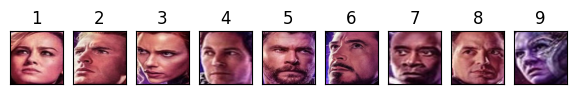

pitha


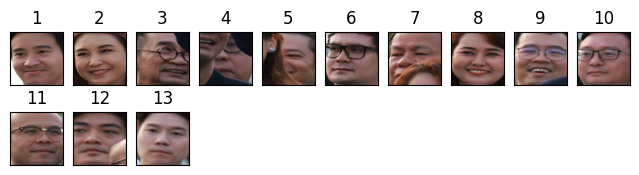

In [178]:
embedding_faces,position,names=detect_all(r"C:\Users\Raum\Desktop\immm\*") # lock by self-image

In [207]:
FACE_LOCK = {NAME:[0,5] for NAME in names}
# ii = plot_result(r"C:\Users\Raum\Desktop\immm\*",embedding_faces,position,names,FACE_LOCK=FACE_LOCK,file_filter=r'C:\Users\Raum\Desktop\jec\code\dataface\dogmeme.png')
# ii = plot_result(r"C:\Users\Raum\Desktop\immm\*",embedding_faces,position,names,FACE_LOCK=[])
ii = plot_result(r"C:\Users\Raum\Desktop\immm\*",embedding_faces,position,names,FACE_LOCK=FACE_LOCK)

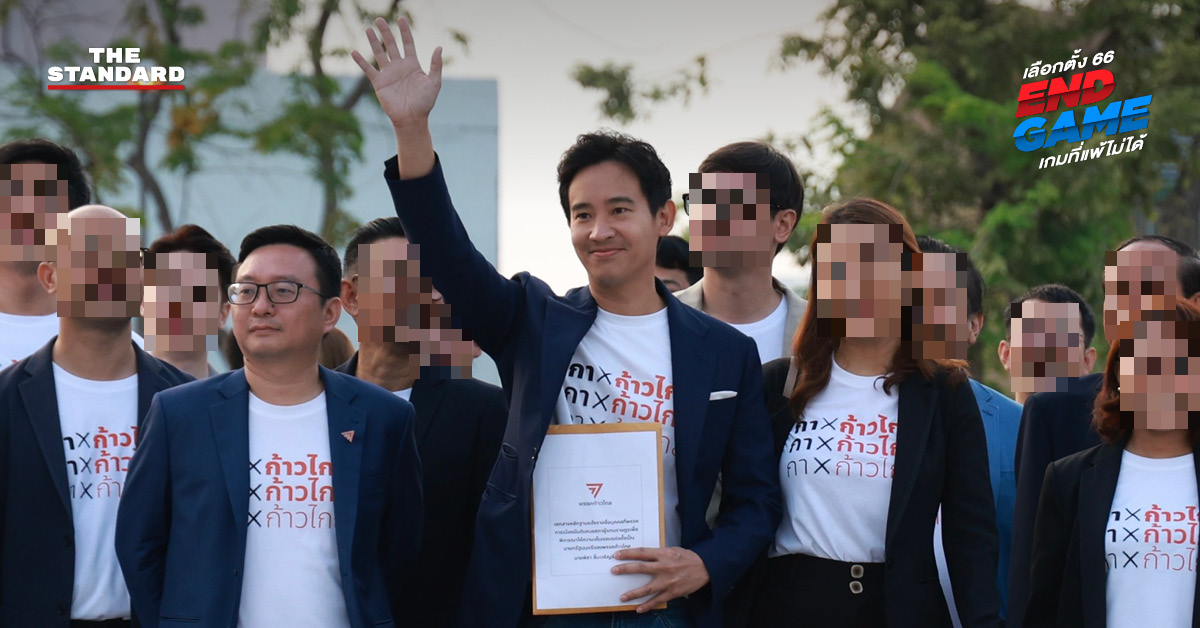

In [208]:
ii['pitha']